# ML: Supervised algorithm - L1, L2 regularisation - Fat Content in Food

## Introduction

Train a regression model to help us determine the fat content of a certain food product. We have a set of 100 predictor variables associated with the absorption channel spectrum. 

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

## 2. Load datasets

Access the faraway meatspec dataset.

In [2]:
import faraway.datasets.meatspec

## 3. Dataset analysis

In [3]:
data = faraway.datasets.meatspec.load()
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
4,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
5,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


As you can see in the table above, we have a total of 100 predictor variables. Overall, given the number of entries we have, this could be considered a fairly high number of variables. Let's do an analysis of the correlations of these variables.

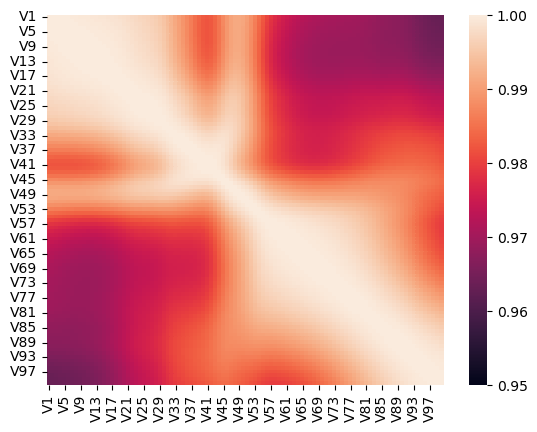

In [4]:
# Any existing correlation?
corrMatrix = data.iloc[:, :100].corr()
sns.heatmap(corrMatrix, vmin = 0.95, vmax=1)
plt.show()

From the figure, most of the variables are highly correlated, with values above 0.98 for most of them. So applying a regularisation method is a good strategy for this problem. 

## 4. Train model

Divide the sample into two partitions, one for training and one for testing. In this case we will use 30% of the data for the test set. 

In [5]:
X = data.iloc[:,:100]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 0.7, 
                                                    random_state = 1234)

Train a linear regression model with the default parameters. This model will serve as a basis for evaluating possible improvements when applying the regularisation methods. 

In [6]:
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)

LinearRegression()

Let's visualise the result with the following piece of code:

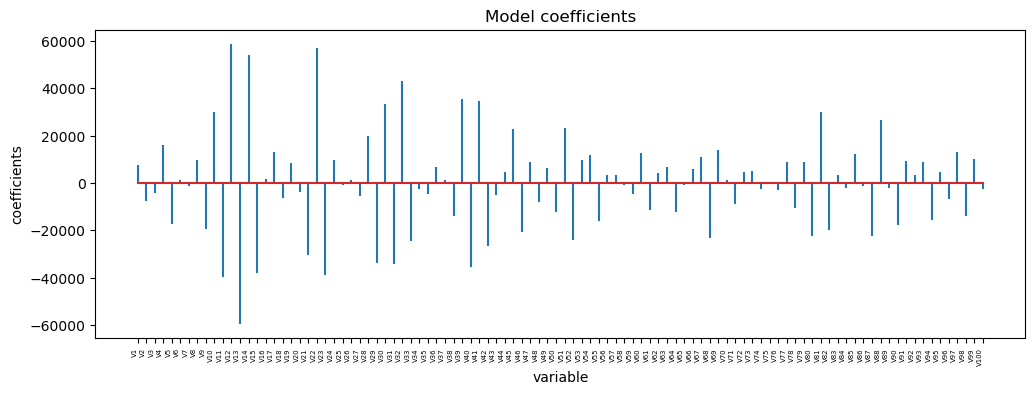

In [7]:
df_coeficientes = pd.DataFrame({'predictor': X_train.columns, 'coef': modelo.coef_.flatten()})

fig, ax = plt.subplots(figsize=(12, 4))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ', use_line_collection=True)
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coefficients')
ax.set_title('Model coefficients');

Predictor variables with coefficients vary between [-60,000, 60,000] accompanied by other smaller coefficients in terms of their order of magnitude. 

Finally, let's calculate the error, in this case the MSE (mean square error) to have a basis for comparison when applying the regularisations.

In [8]:
# Test predictions
predicciones = modelo.predict(X=X_test)

# Ordinary Least Squares
mse_ols = mean_squared_error(y_true = y_test, y_pred = predicciones, squared = True)
# If squared = True returns MSE value, if False returns RMSE value.

print(f"Test MSE: {round(mse_ols,2)}")
print(f"The predictions of the final model are on average {round(mse_ols,2)} units away from the real value.")

Test MSE: 14.74
The predictions of the final model are on average 14.74 units away from the real value.


__Ridge (L2)__: 

In [9]:
# RIDGE - L2
# ==============================================================================
# Model building and training (we tested different values of alpha).
# ==============================================================================
# By default Ridge uses the mean squared error.

# Evolution of coefficients as a function of lambda
# ==============================================================================
lambdas = np.logspace(-11, -3, 100)

coefs = []
mse_ridge = []

for lambda_ in lambdas:
    modelo_temp = Ridge(alpha = lambda_)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())
    
    predicciones = modelo_temp.predict(X=X_test)
    mse_ridge.append(mean_squared_error(
    y_true = y_test,
    y_pred = predicciones,
    squared = True
    ))

Apply Ridge's regularisation. As we want to observe the influence of the parameter λ, we will make a sweep of different values to later compare the error obtained in each of the cases. 

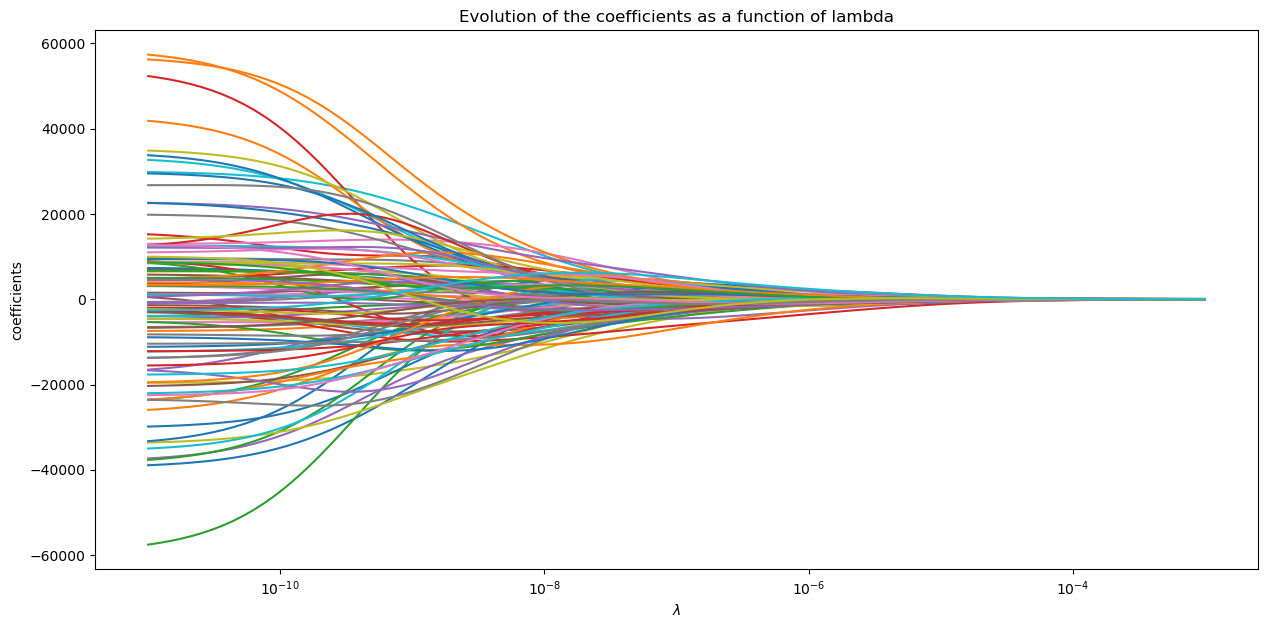

In [10]:
# Plot evolution of the coefficients as a function of lambda
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('coefficients')
ax.set_title('Evolution of the coefficients as a function of lambda');
plt.show()

From the graph obtained, you can see how the coefficients of the model vary as we have higher λ values. 

In [11]:
# Get the lambda that returns the lowest mean error.
min_mse_ridge = min(mse_ridge)
index_min_mse = mse_ridge.index(min_mse_ridge)
min_mse_lambda = lambdas[index_min_mse]

print(f"The lowest lambda parameter (MSE) is: {min_mse_lambda}")
print(f"The predictions of the final model are on average far off {round(min_mse_ridge,2)} real value units.")

The lowest lambda parameter (MSE) is: 3.764935806792471e-06
The predictions of the final model are on average far off 4.62 real value units.


Keep the regularisation parameter λ with which we have obtained the smallest mean square error (MSE). 

With this type of regularisation, we mitigate the correlation effects of the predictor variables.

In this case, we have managed to reduce the mean squared error compared to the baseline model we ran previously. 

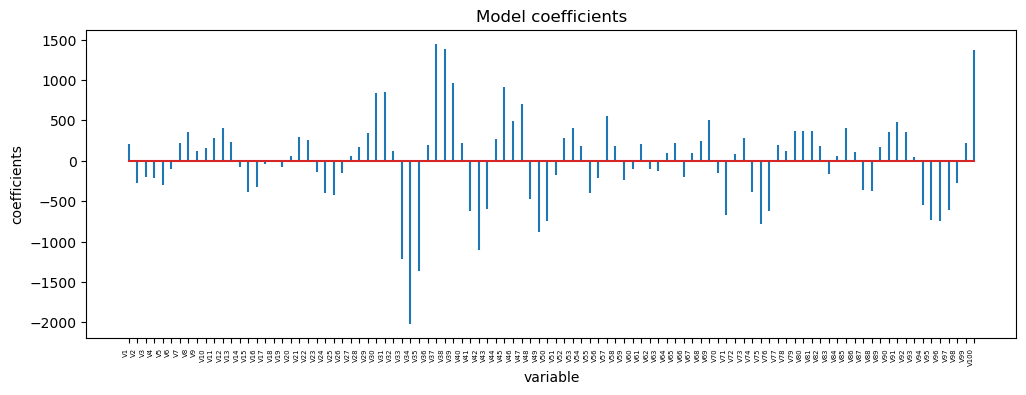

In [12]:
# Model coefficients
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': coefs[index_min_mse]}
                  )

fig, ax = plt.subplots(figsize=(12, 4))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ', use_line_collection=True)
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coefficients')
ax.set_title('Model coefficients');

Plot the value of the coefficients of the final model (with the previous value of λ). We can see that the reduction in the magnitude of the coefficients is significant, having now values between [-1500, 2000] approximately. 

__Lasso (L1)__: 

In [13]:
# LASSO - L1
# ==============================================================================
# Model building and training (we tested different values of alpha).
# ==============================================================================
# By default Lasso uses the mean squared error.

# Evolution of coefficients as a function of lambda
# ==============================================================================
lambdas = np.logspace(-3.8, 0, 100)
coefs = []
mse_lasso = []

for lambda_ in lambdas:
    modelo_temp = Lasso(alpha=lambda_, selection='random', max_iter = 250000, tol = 0.01)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())
    
    predicciones = modelo_temp.predict(X = X_test)
    mse_lasso.append(mean_squared_error(
    y_true = y_test,
    y_pred = predicciones,
    squared = True
    ))

Replicamos el procedimiento pero esta vez con la regularización de Lasso.

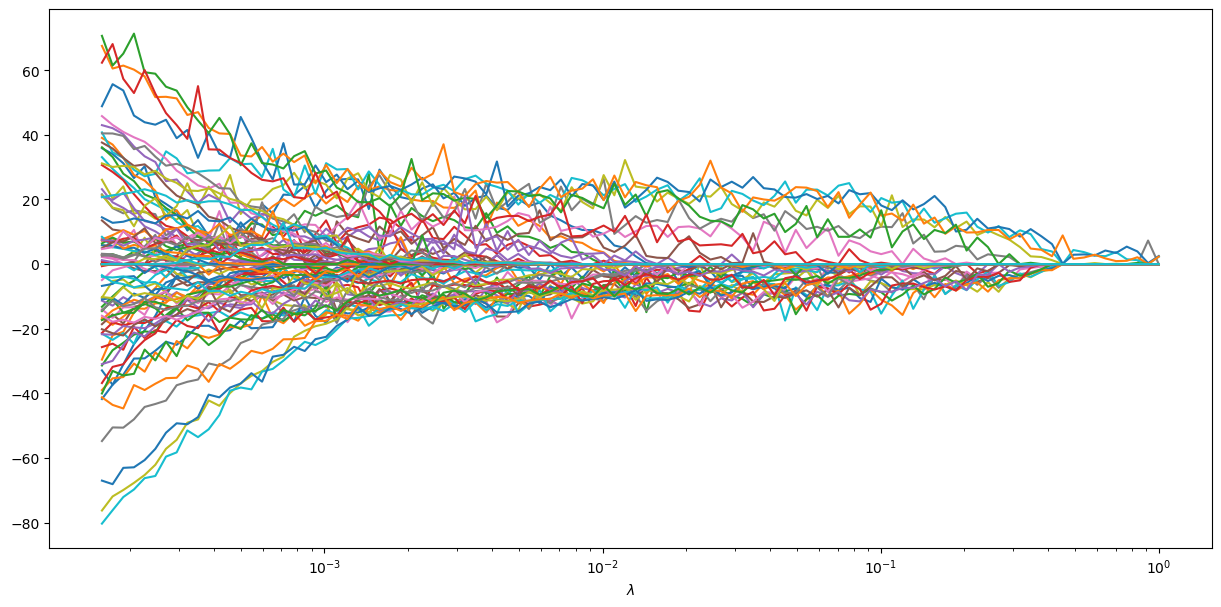

In [14]:
# Plot evolution of the coefficients as a function of lambda
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlabel('$\lambda$') 
plt.show()

Observe that the coefficients can indeed go to zero and additionally, the convergence has a little more variability. 

Finally, we can obtain the regularisation parameter with which we obtained the smallest mean squared error (MSE) together with the error obtained. On the other hand, it is observed that the final model remains with 83 of the 100 initial variables. In the same way, it has a better error than the one obtained in the linear regression model without regularisations. 

In [15]:
# Obtén el lambda que nos devuelve menor error medio
# ==============================================================================
min_mse_lasso = min(mse_lasso)
index_min_mse = mse_lasso.index(min_mse_lasso)
min_mse_lambda = lambdas[index_min_mse]
l1_coef = coefs[index_min_mse]
p_variables = sum(abs(l1_coef)>0)

print(f"The lowest lambda parameter (MSE) is: {min_mse_lambda}")
print(f"The final model predictions are, on average, far off. {round(min_mse_lasso,2)} real value units.")
print(f"These predictions are achieved by {p_variables} variables")

The lowest lambda parameter (MSE) is: 0.0011077568505097088
The final model predictions are, on average, far off. 9.85 real value units.
These predictions are achieved by 81 variables


To conclude, we can explore the magnitude of the coefficients of the linear regression model with L1 regularisation. Here we find significantly smaller values in order of magnitude compared to the base model.

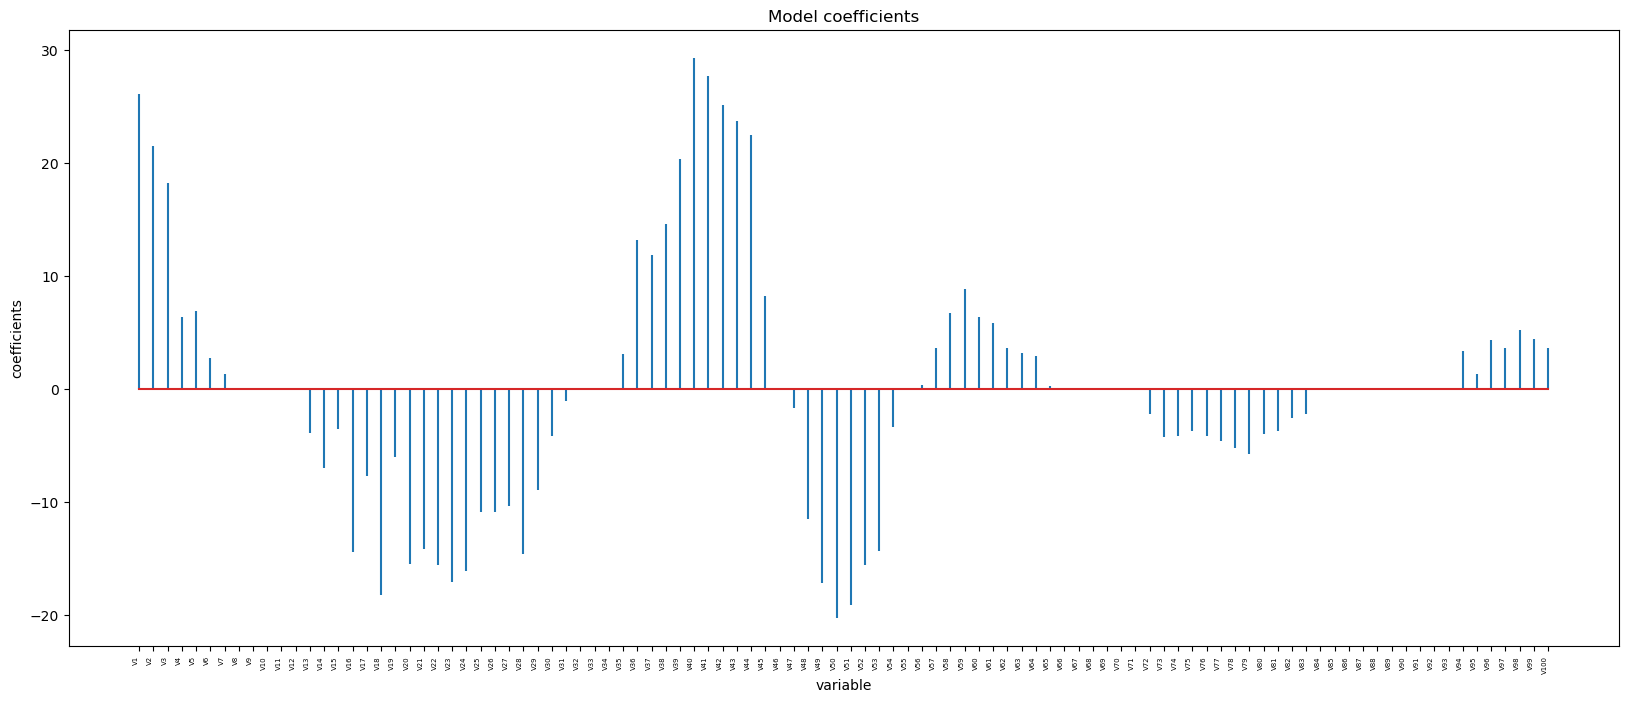

In [16]:
# Model coefficients
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': coefs[index_min_mse]}
                  )

fig, ax = plt.subplots(figsize=(20, 8))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ', use_line_collection=True)
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coefficients')
ax.set_title('Model coefficients');